# Sentiment Analysis: Statistical Insights

This notebook demonstrates statistical analyses to gain insights from sentiment predictions generated by a BERT-based multi-task sentiment analysis model. The analyses include:
1. Correlation analysis between aspects
2. Word clouds for sentiment-aspect associations
3. Sentiment distribution analysis
4. Aspect importance analysis
5. Sentiment trend analysis over time
6. Sentiment co-occurrence analysis

We assume a dataset of Chinese restaurant reviews with sentiment labels for 18 aspects (e.g., Food#Taste, Service#Hospitality). For demonstration, we simulate a small dataset.

In [32]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import jieba
from itertools import combinations
from datetime import datetime
from model import MultiTaskSentimentModel
from schemas import ReviewInput

%matplotlib inline

## 1. Load Training Data

We the training data to simulate a dataset that is predicted using our models. In practice, replace this with the actual dataset of a restaurant.

In [33]:
aspects = MultiTaskSentimentModel.ASPECT_COLUMNS
sentiment_map = {0: "not_mentioned", 1: "negative", 2: "neutral", 3: "positive"}
reverse_sentiment_map = {v: k for k, v in sentiment_map.items()}


# Read the data
data = pd.read_csv("../data/train.csv")

df = pd.DataFrame(data)

## 3. Correlation Analysis

Compute and visualize correlations between aspect sentiments to identify relationships.

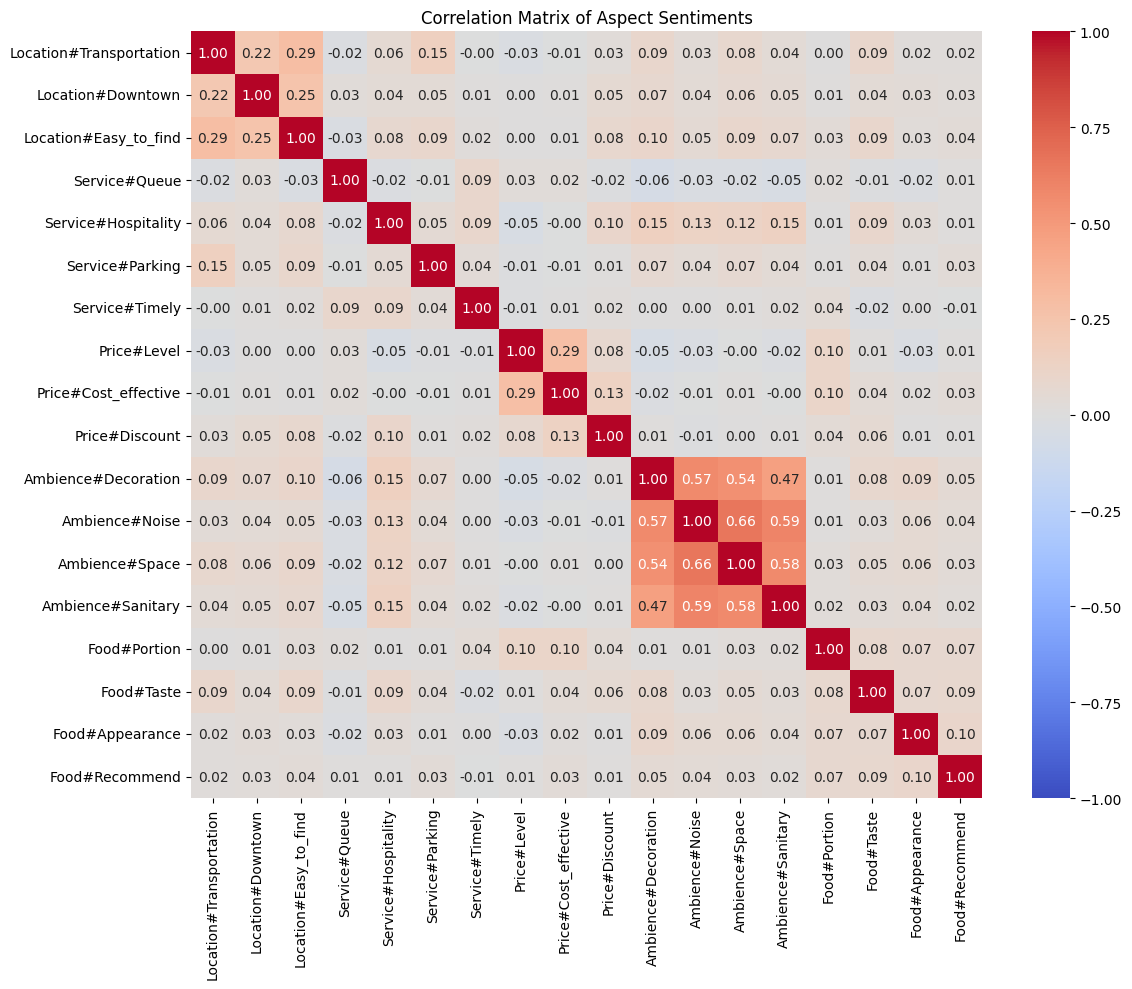

In [34]:
numerical_df = df[aspects].replace(reverse_sentiment_map)

# Compute Spearman correlation matrix
corr_matrix = numerical_df.corr(method="spearman")

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix of Aspect Sentiments")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

**Interpretation**: Strong positive correlations (red) indicate aspects that tend to have similar sentiments. For example, a high correlation between Price#Level and Price#Cost_effective

## 4. Word Clouds for Sentiment-Aspect Associations

Generate word clouds for words associated with specific sentiments in each aspect.

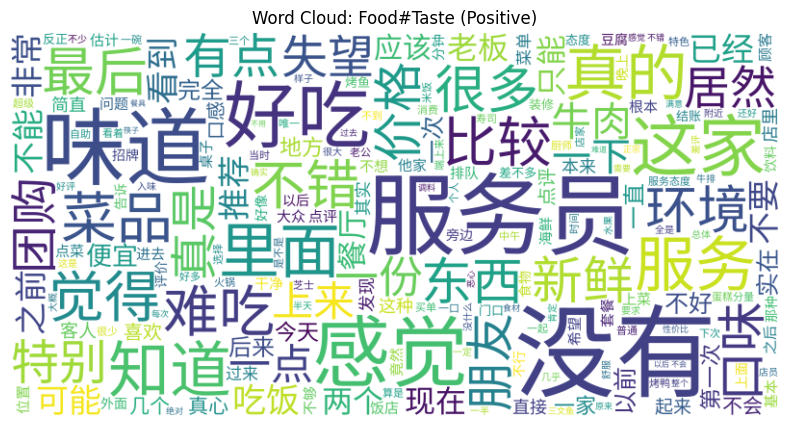

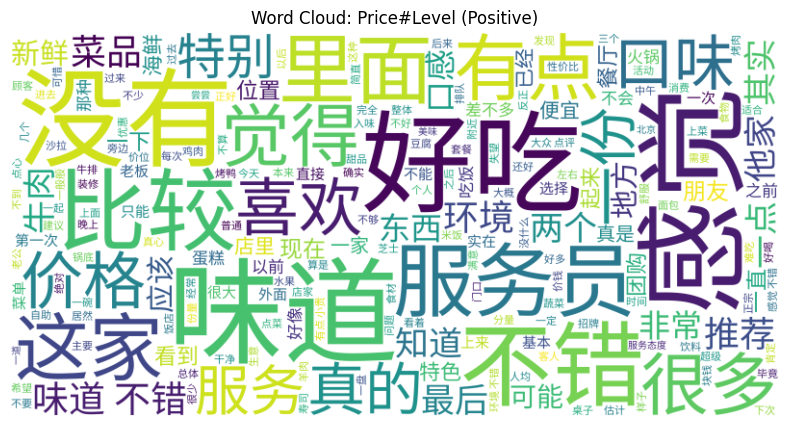

In [ ]:
# Example: Word cloud for positive Food#Taste
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import jieba

FONT_PATH = "../NotoSansSC-Regular.ttf"  # Your specified font path
aspects = ["Food#Taste", "Price#Level"]
sentiments = [-1, 1]

# Load stop words from file
try:
    with open("stop_words.txt", "r", encoding="utf-8") as f:
        stop_words = set(f.read().strip().split("\n"))
except FileNotFoundError:
    print("Error: stop_words.txt not found. Using a minimal stop words set.")
    stop_words = {
        "的",
        "是",
        "在",
        "了",
        "和",
        "很",
        "就",
        "也",
        "都",
        "这",
        "那",
        "个",
        "不",
        "没有",
    }


def generate_wordcloud(texts, sentiment, aspect):
    if not texts.empty:
        # Tokenize with jieba and remove stop words
        words = []
        for text in texts:
            tokens = jieba.cut(text)
            filtered_tokens = [
                token for token in tokens if token not in stop_words and len(token) > 1
            ]
            words.extend(filtered_tokens)
        text = " ".join(words)

        # Generate word cloud
        try:
            wordcloud = WordCloud(
                font_path=FONT_PATH, width=800, height=400, background_color="white"
            ).generate(text)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"Word Cloud: {aspect} (Positive)")
            plt.savefig(f"wordcloud_{aspect}_positive.png")
            plt.show()
        except OSError as e:
            print(f"Error loading font at {FONT_PATH}: {e}")
            print("Please verify the font path or install Noto Sans SC.")
    else:
        print(
            f"No reviews found for {aspect} with {sentiment} sentiment. Trying alternative."
        )


for sentiment in sentiments:
    for aspect in aspects:
        texts = df[df[aspect] == sentiment]["review"]
        generate_wordcloud(texts, sentiment, aspect)

**Interpretation**: The word cloud highlights frequent terms in positive Food#Taste reviews (e.g., '美味', '好吃'). Repeat for other aspects/sentiments as needed.

## 6. Aspect Importance Analysis

Estimate aspect importance based on mention frequency (non-'not_mentioned' sentiments).

In [ ]:
# Count mentions
importance = {aspect: (df[aspect] != "not_mentioned").sum() for aspect in aspects}

# Plot
plot_df = pd.DataFrame(
    {"Aspect": list(importance.keys()), "Mentions": list(importance.values())}
)
fig = px.bar(
    plot_df, x="Aspect", y="Mentions", title="Aspect Importance (Mention Frequency)"
)
fig.update_layout(xaxis_tickangle=45)
fig.write_html("aspect_importance.html")
fig.show()

**Interpretation**: Aspects with more mentions (e.g., Food#Taste) are likely more critical to customers.

## 7. Sentiment Trend Analysis

Analyze sentiment trends over time (by month).

In [ ]:
# Group by month
df["month"] = df["timestamp"].dt.to_period("M")
trend_data = {}
for aspect in aspects:
    trend = df.groupby("month")[aspect].value_counts().unstack().fillna(0)
    trend_data[aspect] = trend

# Prepare data for plotting
plot_df = pd.DataFrame(
    [
        {"Month": str(month), "Aspect": aspect, "Sentiment": sentiment, "Count": count}
        for aspect, trends in trend_data.items()
        for month, counts in trends.iterrows()
        for sentiment, count in counts.items()
    ]
)

# Plot
fig = px.line(
    plot_df,
    x="Month",
    y="Count",
    color="Sentiment",
    facet_col="Aspect",
    facet_col_wrap=3,
    title="Sentiment Trends by Aspect",
)
fig.update_layout(height=800)
fig.write_html("sentiment_trends.html")
fig.show()

**Interpretation**: Trends show whether sentiments are improving or declining (e.g., increasing positive Food#Taste over time).

## 8. Sentiment Co-Occurrence Analysis

Analyze how often sentiments co-occur across aspects.

In [ ]:
# Count co-occurrences
cooccurrences = {}
for _, row in df[aspects].iterrows():
    pred = row.to_dict()
    for (asp1, sent1), (asp2, sent2) in combinations(pred.items(), 2):
        if sent1 != "not_mentioned" and sent2 != "not_mentioned":
            key = f"{asp1}:{sent1} -> {asp2}:{sent2}"
            cooccurrences[key] = cooccurrences.get(key, 0) + 1

# Top 10 co-occurrences
top_cooccurrences = sorted(cooccurrences.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Sentiment Co-Occurrences:")
for key, count in top_cooccurrences:
    print(f"{key}: {count}")

# Optional: Visualize as a network graph (requires networkx)
# import networkx as nx
# G = nx.Graph()
# for key, count in cooccurrences.items():
#     asp1_sent, asp2_sent = key.split(' -> ')
#     G.add_edge(asp1_sent, asp2_sent, weight=count)
# ... (add plotting code)

**Interpretation**: Frequent co-occurrences (e.g., positive Food#Taste with positive Service#Hospitality) indicate common customer experience patterns.

## 9. Save Results

All plots are saved as files (PNG or HTML) for user reference.

In [ ]:
# Summary of saved files
print("Saved files:")
print("- correlation_heatmap.png")
print("- wordcloud_Food#Taste_positive.png")
print("- sentiment_distribution.html")
print("- aspect_importance.html")
print("- sentiment_trends.html")

## Conclusion

This notebook demonstrates how to analyze sentiment predictions to gain insights. To use with your actual training data:
1. Replace the simulated data with your dataset (e.g., load from CSV).
2. Ensure the `SimHei.ttf` font is available for Chinese word clouds.
3. Adjust visualization parameters (e.g., figure sizes, colors) as needed.

These analyses can be integrated into your FastAPI app as endpoints for user access.